In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime


In [10]:
%matplotlib notebook
import matplotlib.pyplot as plt
import sys
sys.path
sys.path.append('/Users/chenglingyun/Desktop/interactive-anomaly-detection/examples')
from intand import datasets, Evaluation, feedback_loop
from intand.ensembles import IsoForest
from intand.models import Unsupervised, OJRank, OMD, AAD

import intand
print("VERSION:", intand.__version__)


VERSION: 0.1.0


In [11]:
################### Loading the data
df = pd.read_csv("5544c26ecd130b116b28a36c.csv", index_col=0, parse_dates=True)
t1, t2 = datetime(2018, 3, 12), datetime(2018, 3, 17) # compressor failure period: from t1 to t2

#### haven't done: mark the time period represent another cause

df columns: Index(['Compressor_mean', 'AditionalHeat_mean', 'HotWater_mean',
       'OutsideTemp_mean'],
      dtype='object')


<IPython.core.display.Javascript object>


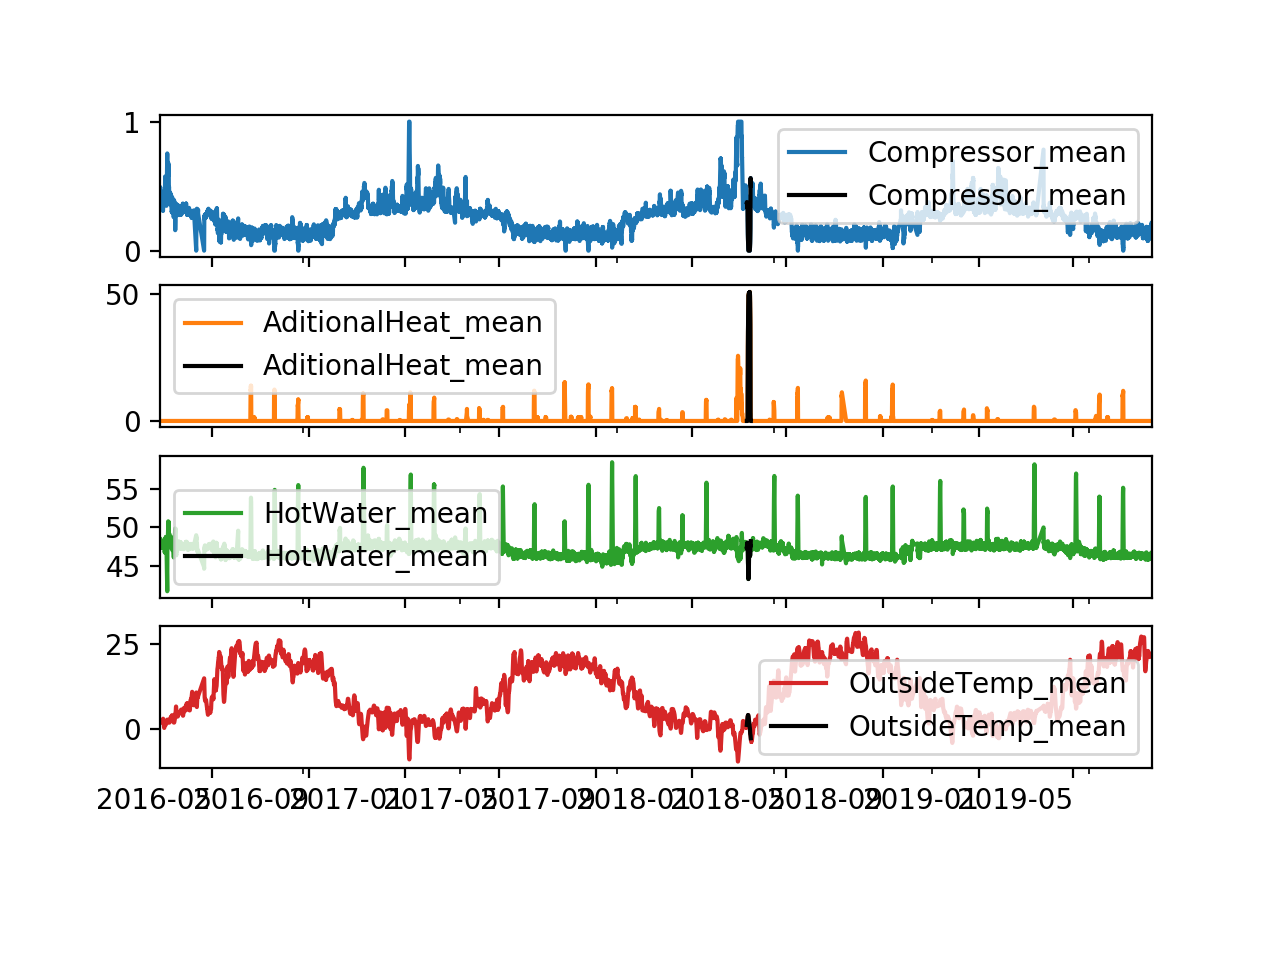

In [12]:
print("df columns:", df.columns)
ax = df.plot(subplots=True) # Plot the data (with all features) over time
ax = df[t1 : t2].plot(subplots=True, color="black", ax=ax) # plot in black the period where the failure happened
plt.show()


In [13]:
# Adding a column "labels" withs values -1 (normal) or +1 (abnormal/failure)
df.loc[:, "labels"] = -1
df.loc[t1 : t2, "labels"] = 1

X = df.values[:, :-2]  # We ignore the two last columns (corresponding to "OutsideTemp_mean" and "labels")
y = df["labels"].values

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (28371, 3)
y shape: (28371,)


<IPython.core.display.Javascript object>


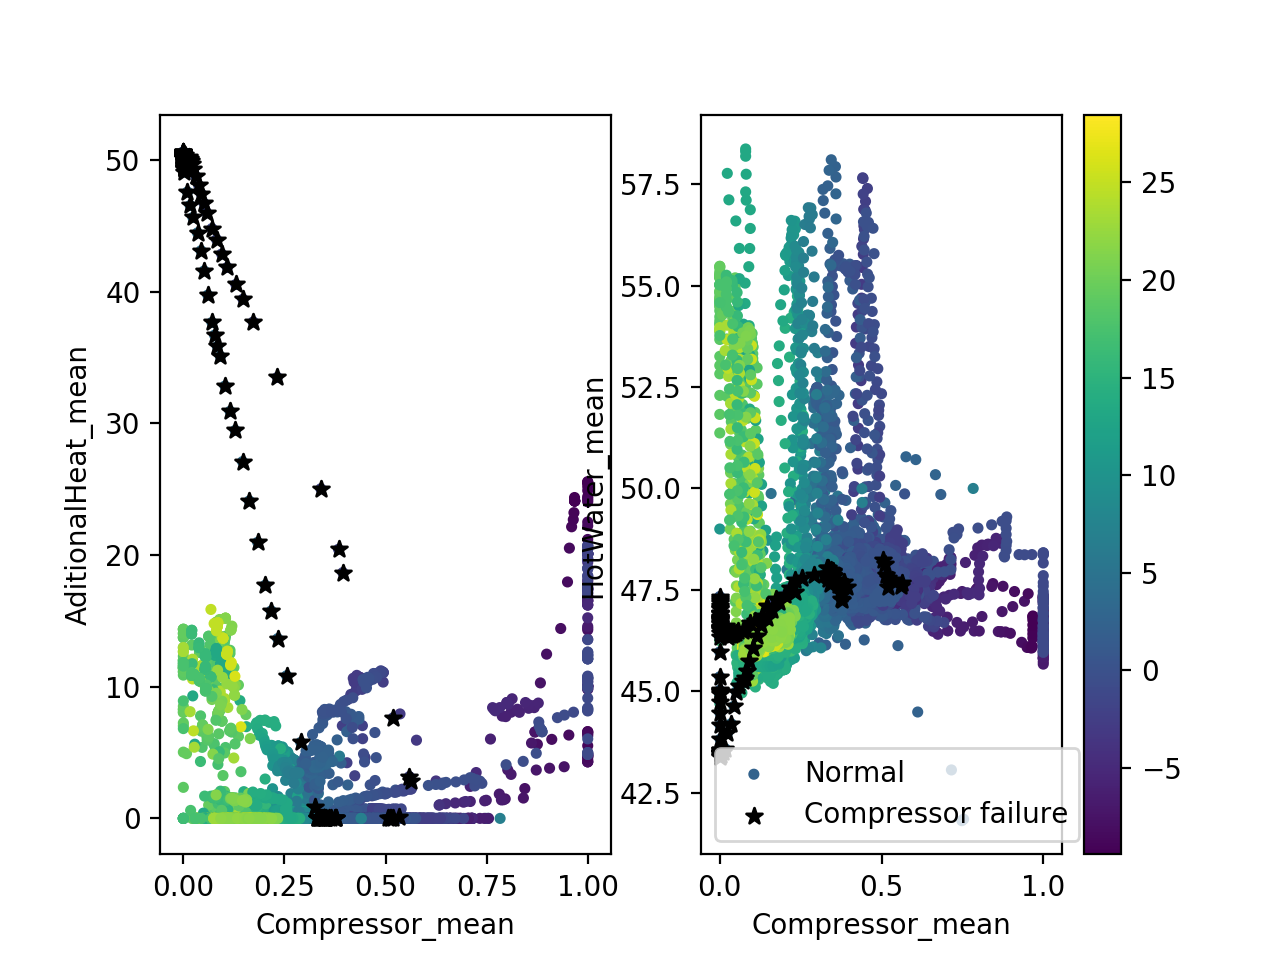

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.set_xlabel("Compressor_mean")
ax1.set_ylabel("AditionalHeat_mean")

ax2.set_xlabel("Compressor_mean")
ax2.set_ylabel("HotWater_mean")

colors = df["OutsideTemp_mean"].values # Using the outside temperature as colors (to show some context)

cax = ax1.scatter(X[:, 0], X[:, 1], marker=".", c=colors, label="Normal")
cax = ax2.scatter(X[:, 0], X[:, 2], marker=".", c=colors, label="Normal")

In [15]:
X1 = X[y == 1]  # subset of anomalous data (where label is +1)
# Re-plotting anomalies with a different marker (*) and color (black)
ax1.scatter(X1[:, 0], X1[:, 1], marker="*", color="black", label="Compressor failure")
ax2.scatter(X1[:, 0], X1[:, 2], marker="*", color="black", label="Compressor failure")

plt.colorbar(cax)
plt.legend()
plt.show()


In [16]:
Z = IsoForest(n_trees=20).fit(X).transform(X)

Total: 1 (0 anomalies, 1 nominals)

<IPython.core.display.Javascript object>


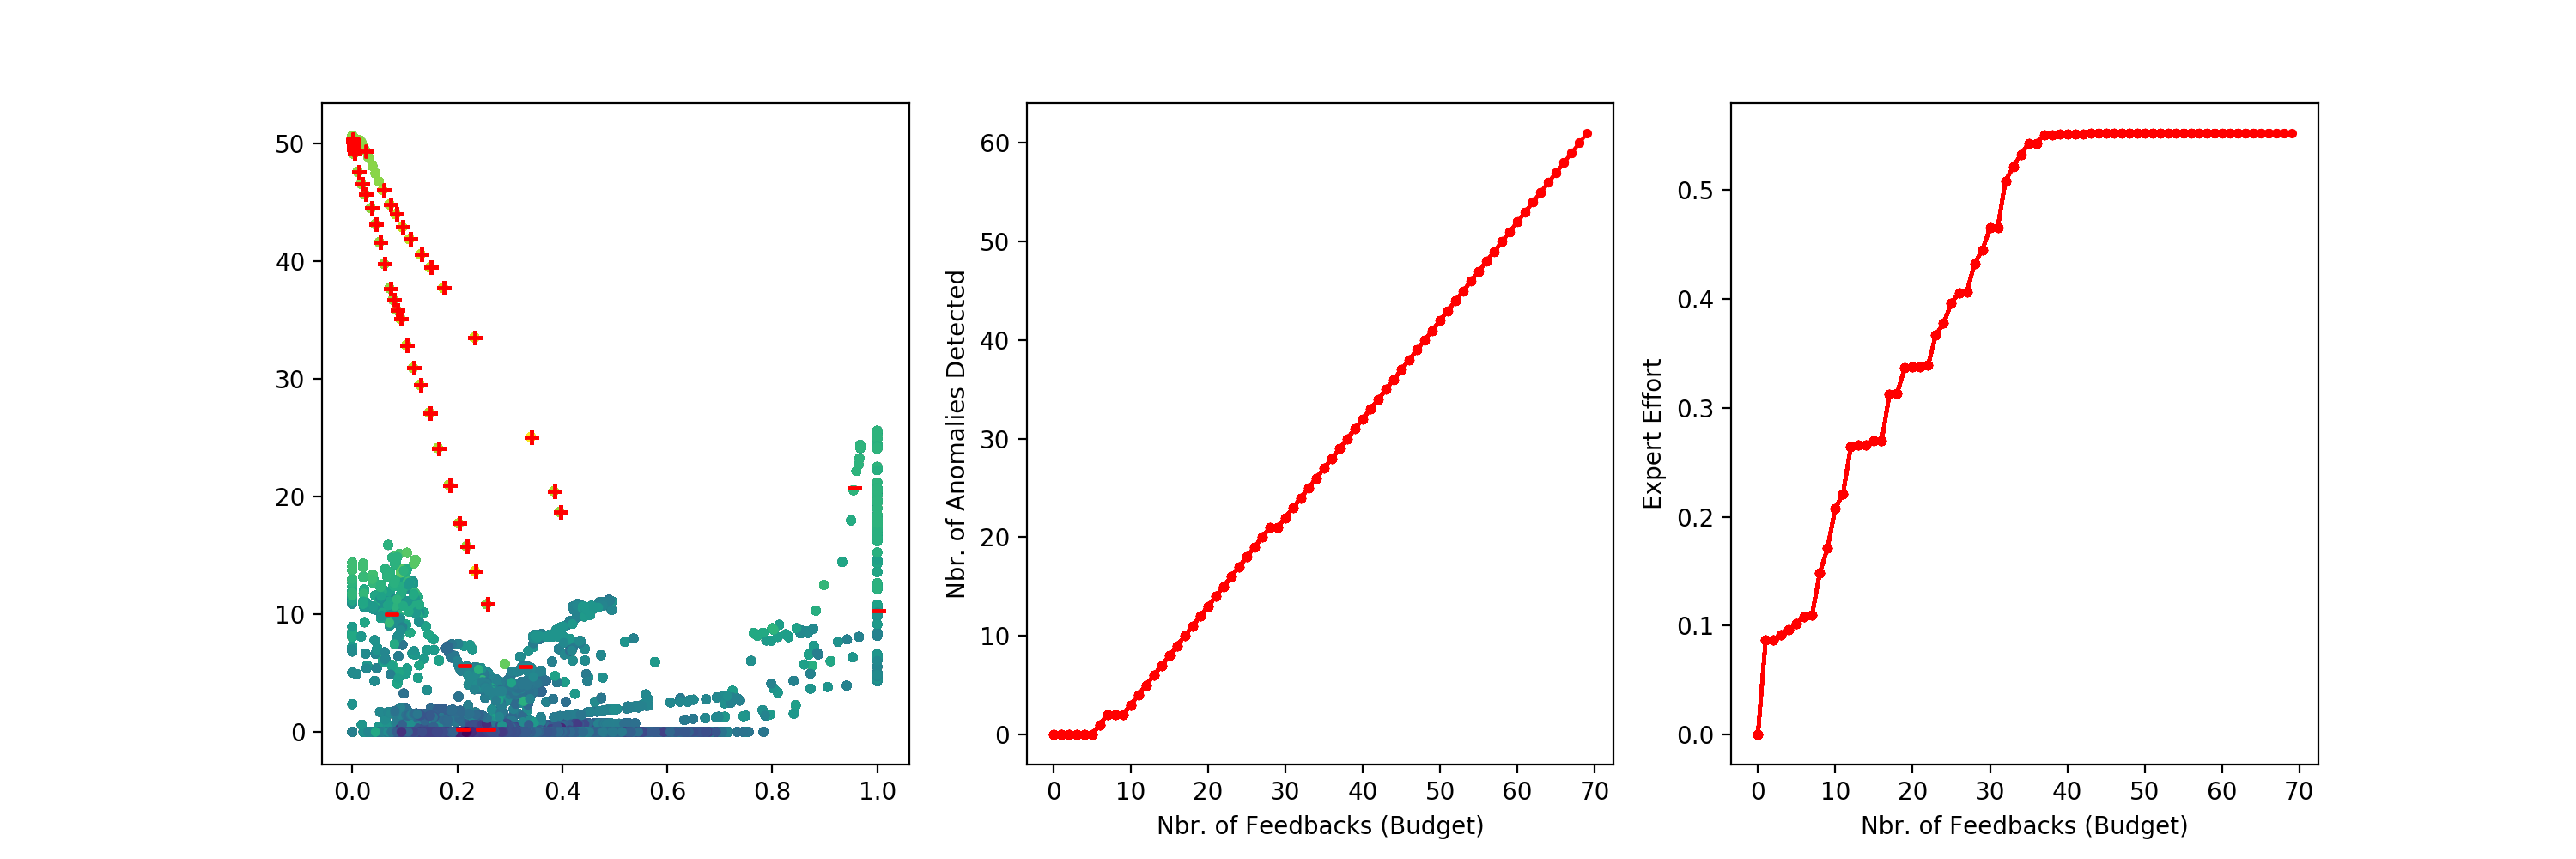

Total: 70 (61 anomalies, 9 nominals)

In [17]:
model = OJRank(Z, X, plot=True)  # Instanciating a model (set plot to False if you don't want visualization)

budget = 70
for itr in range(budget):
    i = model.get_top1()  # get the index of the most anomalous instance
    feedback = y[i]       # present the selected instance to an expert and get a feedback
    model.update(i, feedback)